# Clustering data into groups using K-means and DBSCAN

*Clustering* is the process of organizing data points into conceptually meaningful groups. What makes a given group “conceptually meaningful”? There is no easy answer to that question. The usefulness of any clustered output is dependent on the task we’ve been assigned.

Imagine that we’re asked to cluster a collection of pet photos. Do we cluster fish and lizards in one group and fluffy pets (such as hamsters, cats, and dogs) in another? Or should hamsters, cats, and dogs be assigned three separate clusters of their own? If so, perhaps we should consider clustering pets by breed. Thus, Chihuahuas and Great Danes fall into diverging clusters. Differentiating between dog breeds will not be easy. However, we can easily distinguish between Chihuahuas and Great Danes based on breed size. Maybe we should compromise: we’ll cluster on both fluffiness and size, thus bypassing the distinction between the Cairn Terrier and the similar-looking Norwich Terrier.

Is the compromise worth it? It depends on our data science task. Suppose we work for a pet food company, and our aim is to estimate demand for dog food, cat food, and lizard food. Under these conditions, we must distinguish between fluffy dogs, fluffy cats, and scaly lizards. However, we won’t need to resolve differences between separate dog breeds. Alternatively, imagine an analyst at a vet’s office who’s trying to group pet patients by their breed. This second task requires a much more granular level of group resolution.

Different situations require different clustering techniques. As data scientists, we must choose the correct clustering solution. Over the course of our careers, we will cluster thousands (if not tens of thousands) of datasets using a variety of clustering techniques. The most commonly used algorithms rely on some notion of centrality to distinguish between clusters.

## Using Centrality to Discover Clusters

Suppose a bull’s-eye is located at a coordinate of `[0, 0]`. A dart is thrown at that coordinate. We’ll model the x and y positions of the dart using 2 Normal distributions.

**Modeling dart coordinates using 2 Normal distributions**

In [ ]:
import numpy as np
np.random.seed(0)
mean = 0
variance = 2
x = np.random.normal(mean, variance ** 0.5)
y = np.random.normal(mean, variance ** 0.5)
print(f"The x coordinate of a randomly thrown dart is {x:.2f}")
print(f"The y coordinate of a randomly thrown dart is {y:.2f}")

The x coordinate of a randomly thrown dart is 2.49
The y coordinate of a randomly thrown dart is 0.57


Lets simulate 5,000 random darts tossed at the bulls'-eye positioned at `[0, 0]`. We'll also simulate 5,000 random darts tossed at a second bull's-eye, positioned at `[0, 6]`. Afterwards, we'll generate a scatter plot of all the random dart coordinates.

**Simulating randomly thrown darts**

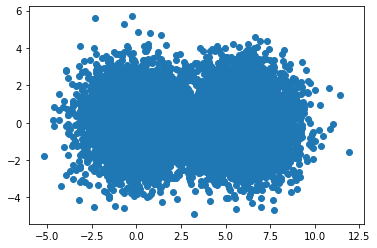

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(1)
bulls_eye1 = [0, 0]
bulls_eye2 = [6, 0]
bulls_eyes = [bulls_eye1, bulls_eye2]
x_coordinates, y_coordinates = [], []
for bulls_eye in bulls_eyes:
    for _ in range(5000):
        x = np.random.normal(bulls_eye[0], variance ** 0.5)
        y = np.random.normal(bulls_eye[1], variance ** 0.5)
        x_coordinates.append(x)
        y_coordinates.append(y)
        
plt.scatter(x_coordinates, y_coordinates)
plt.show()

Lets assign each dart to its nearest bull's-eye. We'll measure dart-proximity using **Euclidean distance**, which is the standard straight-line distance between 2 points. 

**Assigning darts to the nearest bull’s-eye**

In [ ]:
from scipy.spatial.distance import euclidean
def nearest_bulls_eye(dart):
    distances = [euclidean(dart, bulls_e) for bulls_e in bulls_eyes]
    return np.argmin(distances)

darts = [[0,1], [6, 1]]
for dart in darts:
    index = nearest_bulls_eye(dart)
    print(f"The dart at position {dart} is closest to bulls-eye {index}")

The dart at position [0, 1] is closest to bulls-eye 0
The dart at position [6, 1] is closest to bulls-eye 1


Now, we will apply the `nearest_bulls_eye` function to all our computed color coordinates. Afterwards, each dart-point will be plotted using one of 2 colors, in order to distinguish between the 2 bull's-eye assignments.

**Coloring darts based on nearest bull’s-eye**

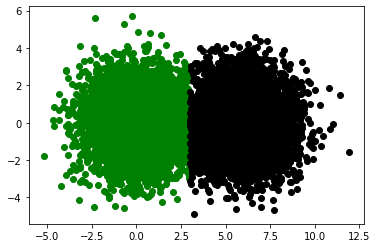

In [ ]:
def color_by_cluster(darts):
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts))
                          if bs_index == nearest_bulls_eyes[i]]
        x_coordinates, y_coordinates = np.array(selected_darts).T
        plt.scatter(x_coordinates, y_coordinates, 
                    color=['g', 'k'][bs_index])
    plt.show()

darts = [[x_coordinates[i], y_coordinates[i]]  
         for i in range(len(x_coordinates))]
color_by_cluster(darts)

The colored darts sensibly split into 2 even clusters. How would we identify such clusters if no central coordinates were provided? Well, one primitive strategy is to simply guess the location of the bull's-eyes.

**Assigning darts to randomly chosen centers**

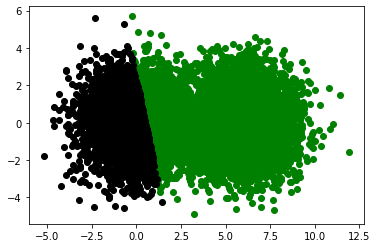

In [ ]:
bulls_eyes = np.array(darts[:2])
color_by_cluster(darts)

Cluster B on the right seems to be stretching way too far to the left.  Lets remedy our error. We 'll compute the mean coordinates of all the points within the stretched right clustered group, and afterwards utilize these coordinates to adjust our estimation of the group's center. We will also reset the left-most cluster's center to its mean prior to re-running our centrality-based clustering.

**Assigning darts to centers based on mean**

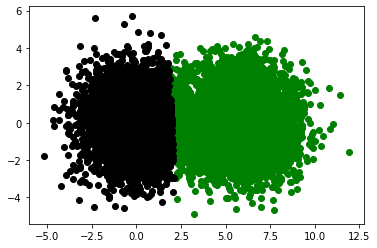

In [ ]:
def update_bulls_eyes(darts):
    updated_bulls_eyes = []
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts))
                          if bs_index == nearest_bulls_eyes[i]]
        x_coordinates, y_coordinates = np.array(selected_darts).T
        mean_center = [np.mean(x_coordinates), np.mean(y_coordinates)]
        updated_bulls_eyes.append(mean_center)
        
    return updated_bulls_eyes

bulls_eyes = update_bulls_eyes(darts)
color_by_cluster(darts)

The cluster's centers still appear a little off. Lets remedy the results by repeating the mean-based centrality adjustment over 10 additional iterations.

**Adjusting bull’s-eye positions over 10 iterations**

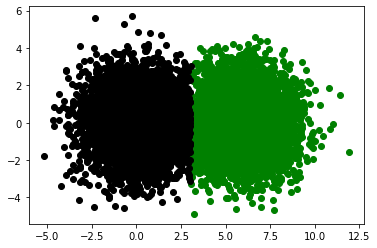

In [ ]:
for i in range(10):
    bulls_eyes = update_bulls_eyes(darts)
    
color_by_cluster(darts)

Now the 2 sets of darts have been perfectly clustered. We have essentially replicated the  **K-means** clustering algorithm, which organizes data using centrality.

## K-Means: A Clustering Algorithm for Grouping Data into K Central Groups

### 10.2.1. K-means Clustering Using Scikit-learn

A speedy implementation of the K-means algorithm is available through the external Scikit-Learn library. Lets import Scikit-learn's `KMeans` clustering class.

In [ ]:
from sklearn.cluster import KMeans

Now, we'll use the `KMeans` class to cluster our `darts` data.

**K-means clustering using Scikit-learn**

In [ ]:
cluster_model = KMeans(n_clusters=2)
assigned_bulls_eyes = cluster_model.fit_predict(darts)

print("Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[0 0 0 ... 1 1 1]


Lets quickly color our darts based on their clustering assignments, in order to confirm that the assignments makes sense.

**Plotting K-means cluster assignments**

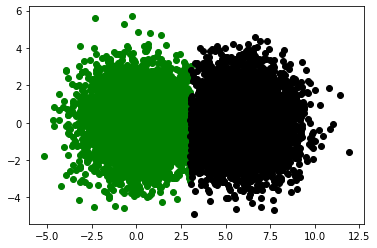

In [ ]:
for bs_index in range(len(bulls_eyes)):
    selected_darts = [darts[i] for i in range(len(darts))
                      if bs_index == assigned_bulls_eyes[i]]
    x_coordinates, y_coordinates = np.array(selected_darts).T
    plt.scatter(x_coordinates, y_coordinates, 
                color=['g', 'k'][bs_index])
plt.show()

Our clustering model has located the centroids in the data. Now, we can reuse these centroids to analyze new data-points that the model has not seen before.

**Using `cluster_model` to cluster new data**

In [ ]:
new_darts = [[500, 500], [-500, -500]]
new_bulls_eye_assignments = cluster_model.predict(new_darts)
for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

Dart at [500, 500] is closest to bull's-eye 1
Dart at [-500, -500] is closest to bull's-eye 0


### Selecting the Optimal K Using the Elbow Method

We estimate an appropriate value for K using a technique known as the **Elbow method**. The Elbow method depends on a calculated value called **inertia**, which is the sum of the squared distances between each point and its closest K-means center. We'll run the technique by plotting the inertia of our dartboard dataset over a large range of K values.

**Plotting the K-means inertia**

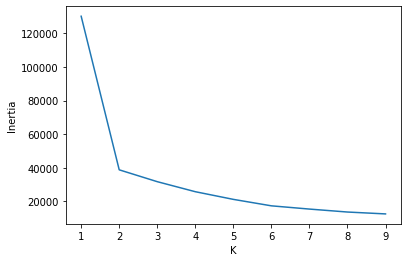

In [ ]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(darts).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The generated plot resembles an arm bent at the elbow. The elbow points directly to a K of 2. What will happen if the number of centers is increased? We can find out by adding an additional bull's-eye to our dart-throwing simulation.

**Plotting inertia for a 3-dartboard simulation**

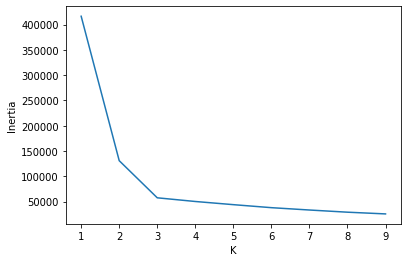

In [ ]:
new_bulls_eye = [12, 0]
for _ in range(5000):
    x = np.random.normal(new_bulls_eye[0], variance ** 0.5)
    y = np.random.normal(new_bulls_eye[1], variance ** 0.5)
    darts.append([x, y])

inertia_values = [KMeans(k).fit(darts).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

## Using Density to Discover Clusters

Suppose that an astronomer discovers a new planet at the far-flung edges of the solar system. The plant, much like our Saturn, has multiple rings spinning in constant orbit around its center. Each ring is formed from thousands of rocks. We'll model these rocks as individual points, defined by x and y coordinates.

**Simulating rings around a planet**

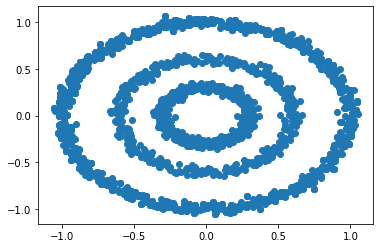

In [ ]:
from sklearn.datasets import make_circles

x_coordinates = []
y_coordinates = []
for factor in [.3, .6, 0.99]:
    rock_ring, _ = make_circles(n_samples=800, factor=factor,
                                noise=.03, random_state=1)
    for rock in rock_ring:
        x_coordinates.append(rock[0])
        y_coordinates.append(rock[1])

plt.scatter(x_coordinates, y_coordinates)
plt.show()

Three ring-groups are clearly present in the plot. Lets search for these 3 clusters using K-means.

**Using K-means to cluster rings**

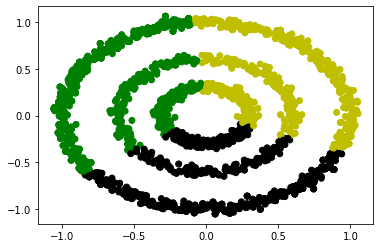

In [ ]:
rocks = [[x_coordinates[i], y_coordinates[i]]  
          for i in range(len(x_coordinates))]
rock_clusters = KMeans(3).fit_predict(rocks)

colors = [['g', 'y', 'k'][cluster] for cluster in  rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

The output is an utter failure! We need to design an algorithm that will cluster data within dense regions of space. One simple definition of density is as follows; a point is in a dense region only if it's located within a distance `epsilon` of `min_points` other points.  Below, we'll set `epsilon` to 0.1 and `min_points` to 10.

**Specifying density parameters**

In [ ]:
epsilon=0.1
min_points = 10

Lets analyze the density of the first rock in our `rocks` list. We'll begin by searching for all the other rocks that are within `epsilon` units of `rocks[0]`.

**Finding the neighbors of `rocks[0]`**

In [ ]:
neighbor_indices = [i for i, rock in enumerate(rocks[1:])
                    if euclidean(rocks[0], rock) <= epsilon]

Now, we'll compare the number of neighbors to `min_points`, in order to determine if `rocks[0]` lies in a dense region of space.

**Checking the density of `rocks[0]`**

In [ ]:
num_neighbors = len(neighbor_indices)
print(f"The rock at index 0 has {num_neighbors} neighbors.")

if num_neighbors >= min_points:
    print("It lies in a dense region.")
else:
    print("It does not lie in a dense region.")

The rock at index 0 has 40 neighbors.
It lies in a dense region.


The rock at index 0 lies in a dense region of space. We can combine `rocks[0]` and its neighbors into a single dense cluster.

**Creating a dense cluster**

In [ ]:
dense_region_indices = [0] + neighbor_indices
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We found a dense cluster containing {dense_cluster_size} rocks")

We found a dense cluster containing 41 rocks


The rock and index 0 and its neighbors form a single 41-element dense cluster. What about the neighbors of the neighbors? By analyzing additional neighboring points, we expand the size of `dense_region_cluster`.

**Expanding a dense cluster**

In [ ]:
dense_region_indices = set(dense_region_indices)
for index in neighbor_indices:
    point = rocks[index]
    neighbors_of_neighbors = [i for i, rock in enumerate(rocks)
                              if euclidean(point, rock) <= epsilon]
    if len(neighbors_of_neighbors) >= min_points:
        dense_region_indices.update(neighbors_of_neighbors)
            
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We expanded our cluster to include {dense_cluster_size} rocks")

We expanded our cluster to include 781 rocks


We can expand our cluster even further by analyzing the density of newly encountered neighbors. Iteratively repeating our analysis will increase the breadth of our cluster boundary. This precedure is known as **DBSCAN**. The DBSCAN algorithm organizes data based on its density distribution.

## DBSCAN: A Clustering Algorithm for Grouping Data Based on Spatial Density

Scikit-Learn makes DBSCAN available for use. We simply need to import the `DBSCAN` class from `sklearn.cluster`. Afterwards, we can initialize the class by assigning `epsilon` and `min_points` using the `eps` and `min_samples` parameters. Lets utilize `DBSCAN` to cluster our 3 rings.

**Using `DBSCAN` to cluster rings**

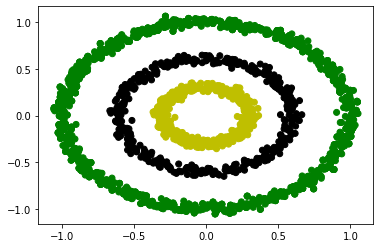

In [ ]:
from sklearn.cluster import DBSCAN
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
rock_clusters = cluster_model.fit_predict(rocks)
colors = [['g', 'y', 'k'][cluster] for cluster in rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

DBSCAN has successfully identified the 3 rock rings. The algorithm succeeded where K-means had failed.

### Comparing DBSCAN and K-means

DBSCAN can filter random outliers located in sparse regions of space. For example, if we add an outlier located beyond the boundary of the rings, then DBSCAN will assign it a cluster id of -1. The negative value indicates that the outlier cannot be clustered with the rest of the dataset.

**Finding outliers using DBSCAN**

In [ ]:
noisy_data = rocks + [[1000, -1000]]
clusters = DBSCAN(eps=epsilon, 
                  min_samples=min_points).fit_predict(noisy_data)
assert clusters[-1] == -1

There is one other advantage to the DBSCAN technique that is missing from K-means. DBSCAN does not depend on Euclidean distance.

### Clustering Based on Non-Euclidean Distance

Suppose we are visiting Manhattan. We wish to know the walking distance from the Empire State Building to Columbus Circle. The Empire State Building is located at the intersection of 34th street and 5th avenue. Meanwhile, Columbus Circle is located is located at the intersection of 57th street and 8th avenue. Our route requires us to walk 26 blocks total. Manhattan's average block-length is .17 miles. Lets compute that walking distance directly using a generalized `manhattan_distance` function.

**Computing the Manhattan distance**

In [ ]:
def manhattan_distance(point_a, point_b):
    num_blocks = np.sum(np.absolute(point_a - point_b))
    return .17 * num_blocks

x = np.array([34, 5])
y = np.array([57, 8])
distance = manhattan_distance(x, y)

print(f"Manhattan distance is {distance} miles")

Manhattan distance is 4.42 miles


Now, suppose we wish to cluster more than 2 Manhattan locations, using DBSCAN. We will pass `metric= manhattan_distance` into the initialization method. Consequently, the clustering distance will correctly reflect the grid-based constraints within the City.

**Clustering using Manhattan distance**

Point at index 0 is in cluster 0
Point at index 1 is in cluster 0
Point at index 2 is in cluster 0
Point at index 3 is an outlier
Point at index 4 is an outlier


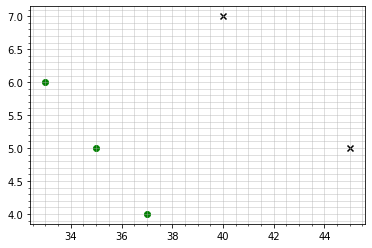

In [ ]:
points = [[35, 5], [33, 6], [37, 4], [40, 7], [45, 5]]
clusters = DBSCAN(eps=1, min_samples=3,
                  metric=manhattan_distance).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"Point at index {i} is an outlier")
        plt.scatter(point[0], point[1], marker='x', color='k')
    else:
        print(f"Point at index {i} is in cluster {cluster}")
        plt.scatter(point[0], point[1], color='g')

plt.grid(True, which='both', alpha=0.5)
plt.minorticks_on()

plt.show()

Unlike K-means, the DBSCAN algorithm does not require our distance function to be linearly divisible. Thus, we can easily run DBSCAN clustering using a ridiculous distance metric.

**Clustering using a ridiculous measure of distance**

In [ ]:
def ridiculous_measure(point_a, point_b):
    is_negative_a = np.array(point_a) < 0
    is_negative_b = np.array(point_b) < 0
    if is_negative_a.all() and is_negative_b.all():
        return 0
    elif is_negative_a.any() and is_negative_b.any():
        return 10
    else:
        return 2

points = [[-1, -1], [-10, -10], [-1000, -13435], [3,5], [5,-7]]
                   
clusters = DBSCAN(eps=.1, min_samples=2,
                  metric=ridiculous_measure).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"{point} is an outlier")
    else:
        print(f"{point} falls in cluster {cluster}")

[-1, -1] falls in cluster 0
[-10, -10] falls in cluster 0
[-1000, -13435] falls in cluster 0
[3, 5] is an outlier
[5, -7] is an outlier


## Analyzing Clusters Using Pandas

We can more intuitively analyze clustered rocks by combining the coordinates and the clusters together in a single Pandas table.

**Storing clustered coordinates in a table**

In [ ]:
import pandas as pd
x_coordinates, y_coordinates = np.array(rocks).T
df = pd.DataFrame({'X': x_coordinates, 'Y': y_coordinates,
                   'Cluster': rock_clusters})

Our Pandas table lets us easily access the rocks in any cluster. Lets plot those rocks that fall into cluster zero.

**Plotting a single cluster using Pandas**

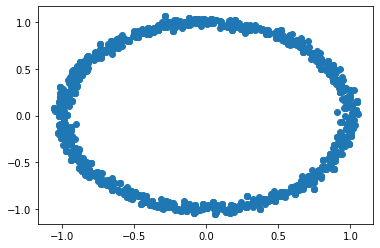

In [ ]:
df_cluster = df[df.Cluster == 0]
plt.scatter(df_cluster.X, df_cluster.Y)
plt.show()

Pandas allows us to obtain a table containing elements from any single cluster. Alternatively, we might want to obtain multiple tables, where each table maps to a cluster id. In Pandas, this can easily be done by calling `df.groupby('Cluster')`.

**Iterating over clusters using Pandas**

Skipping over cluster 0
Plotting cluster 1
Plotting cluster 2


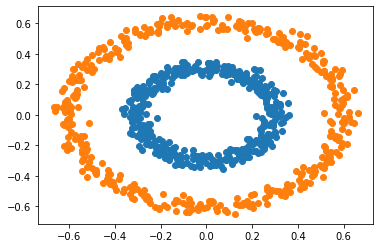

In [ ]:
for cluster_id, df_cluster in df.groupby('Cluster'):
    if cluster_id == 0:
        print(f"Skipping over cluster {cluster_id}")
        continue
    
    print(f"Plotting cluster {cluster_id}")
    plt.scatter(df_cluster.X, df_cluster.Y)

plt.show()